## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import pickle
import json

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc


from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
1263,00000322_002.png,No Finding,2,322,33,M,AP,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000322_002.png
9421,00002443_000.png,No Finding,0,2443,53,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00002443_000.png
30665,00008008_044.png,No Finding,44,8008,23,F,PA,2738,2991,0.143,0.143,NaN,/data/images_004/images/00008008_044.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

unique_finding_list = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x : x.split('|')))))
for c_label in unique_finding_list:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12261,00003192_003.png,No Finding,3,3192,72,F,PA,2798,2729,0.143,...,0,0,0,0,0,1,0,0,0,0
65177,00016092_007.png,No Finding,7,16092,33,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
58581,00014490_000.png,No Finding,0,14490,62,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Not sure why this class is required? As there is already a pneumonia column holding 0 or 1 
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))

In [5]:
len(all_xray_df[all_xray_df['pneumonia_class']==1])

1431

In [6]:
0.8*1431


1144.8

## Create your training and testing data:

In [7]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # There are 1431 pneumonia class 
    # strategy for splitting.. 80% of 1431 -> training 20% -> validation
    # randomly select 1144 of non-pneumonia into training
    # 
    train_data, val_data = train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    return train_data, val_data

In [8]:
t_df, v_df = create_splits(all_xray_df)

In [9]:
len(t_df)


89696

In [10]:
len(v_df)

22424

In [11]:
len(t_df[t_df['pneumonia_class']==1])

1145

In [12]:
train_no_pneuomia_class = t_df[t_df['pneumonia_class']==0].sample(len(t_df[t_df['pneumonia_class']==1])).index.to_list()

In [13]:
# this list already has 1145 pneumonia cases to consider all
train_pneuomia_class = t_df[t_df['pneumonia_class']==1].index.to_list()

In [14]:
# train df to contain equal number of +ve and -ve cases 
# build this one now
train_df = all_xray_df.iloc[train_no_pneuomia_class + train_pneuomia_class]

In [15]:
len(train_df)

2290

In [16]:
# number of non-pneumonia class in train dataframe
len(train_df[train_df['pneumonia_class']==0])

1145

In [17]:
# number of pneumonia class in train dataframe
len(train_df[train_df['pneumonia_class']==1])

1145

In [18]:
train_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
104929,00028145_005.png,Edema|Pneumonia,5,28145,34,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,1
99602,00026374_004.png,Pneumonia,4,26374,87,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,1
90775,00022604_012.png,Edema|Infiltration|Pneumonia,12,22604,26,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,1,0,1
85909,00021201_019.png,Atelectasis|Effusion|Pneumonia,19,21201,65,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,1
87794,00021706_005.png,Pneumonia,5,21706,69,F,PA,2322,2991,0.143,...,0,0,0,0,0,0,0,1,0,1


In [19]:
all_image_paths['00019576_024.png']

'/data/images_009/images/00019576_024.png'

In [20]:
test=plt.imread('/data/images_009/images/00019576_024.png')

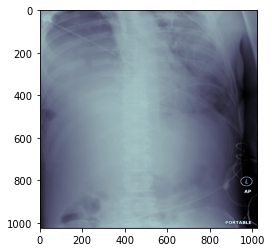

In [21]:
plt.imshow(test,cmap='bone')

In [22]:
# Test and Validation datasets should have absolute paths of the
# image. Let's fix it as another column
train_df['Absolute_paths'] = [all_image_paths[x] for x in train_df['Image Index']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
train_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Absolute_paths
65806,00016244_001.png,Fibrosis,1,16244,60,F,PA,2544,3056,0.139,...,0,0,0,0,0,0,0,0,0,/data/images_008/images/00016244_001.png
69522,00017138_068.png,Pneumonia,68,17138,24,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,1,/data/images_008/images/00017138_068.png
64071,00015809_023.png,Nodule|Pneumonia,23,15809,38,F,AP,3004,2544,0.139,...,0,0,0,0,1,0,1,0,1,/data/images_007/images/00015809_023.png
101395,00026938_000.png,Pneumonia,0,26938,84,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,0,1,/data/images_011/images/00026938_000.png
37803,00009940_003.png,Edema|Infiltration|Pneumonia,3,9940,67,F,AP,2500,2048,0.168,...,0,1,0,0,0,0,1,0,1,/data/images_005/images/00009940_003.png
5673,00001529_002.png,Pneumonia,2,1529,56,F,PA,2714,2991,0.143,...,0,0,0,0,0,0,1,0,1,/data/images_002/images/00001529_002.png
90778,00022604_015.png,Infiltration|Pneumonia,15,22604,26,M,AP,3056,2544,0.139,...,0,1,0,0,0,0,1,0,1,/data/images_010/images/00022604_015.png
16930,00004534_008.png,Cardiomegaly|Pneumonia,8,4534,30,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,0,1,/data/images_003/images/00004534_008.png
106404,00028661_000.png,No Finding,0,28661,53,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,/data/images_012/images/00028661_000.png
54836,00013721_001.png,No Finding,1,13721,15,F,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,/data/images_006/images/00013721_001.png


In [24]:
# Test and Validation datasets should have absolute paths of the
# image. Let's fix it as another column
v_df['Absolute_paths'] = [all_image_paths[x] for x in v_df['Image Index']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
v_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Absolute_paths
57762,00014312_001.png,No Finding,1,14312,79,M,PA,2570,2991,0.143000,...,0,0,0,1,0,0,0,0,0,/data/images_007/images/00014312_001.png
39237,00010294_021.png,Edema|Pneumonia,21,10294,50,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,1,0,1,/data/images_005/images/00010294_021.png
2481,00000634_008.png,No Finding,8,634,70,F,PA,2690,2840,0.143000,...,0,0,0,1,0,0,0,0,0,/data/images_001/images/00000634_008.png
63470,00015658_002.png,No Finding,2,15658,52,M,AP,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,/data/images_007/images/00015658_002.png
83864,00020614_003.png,No Finding,3,20614,33,F,AP,3056,2544,0.139000,...,0,0,0,1,0,0,0,0,0,/data/images_009/images/00020614_003.png
94447,00024216_000.png,No Finding,0,24216,34,M,PA,2992,2991,0.143000,...,0,0,0,1,0,0,0,0,0,/data/images_010/images/00024216_000.png
29351,00007633_001.png,No Finding,1,7633,35,F,AP,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,/data/images_004/images/00007633_001.png
91432,00022815_053.png,Infiltration|Nodule,53,22815,9,M,AP,3056,2544,0.139000,...,0,1,0,0,1,0,0,0,0,/data/images_010/images/00022815_053.png
66760,00016508_001.png,Infiltration,1,16508,50,F,PA,2992,2991,0.143000,...,0,1,0,0,0,0,0,0,0,/data/images_008/images/00016508_001.png
5292,00001406_000.png,No Finding,0,1406,69,M,PA,1870,2021,0.194311,...,0,0,0,1,0,0,0,0,0,/data/images_002/images/00001406_000.png


In [26]:
# we need to convert train_df['pneumonia_class'] & v_df['pneumonia_class'] into str type
# as we are using class mode as 'binary'

train_df['pneumonia_class'] = train_df['pneumonia_class'].astype(str)
v_df['pneumonia_class'] = v_df['pneumonia_class'].astype(str)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
train_df['pneumonia_class'].dtypes


dtype('O')

In [28]:
v_df['pneumonia_class'].dtypes

dtype('O')

In [29]:
# We  now have balanced train_df 
# use train_df and v_df for validation

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [30]:

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0, 
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                horizontal_flip =False,
                                vertical_flip = False,
                                height_shift_range= 0.1,
                                width_shift_range=0.1,
                                rotation_range=10,
                                shear_range =0.1,
                                zoom_range=0.1)
    return my_idg

def my_image_data_gen_val():
    # Validation data generator doesn't need
    # augmentation.. just normalization
    my_idg = ImageDataGenerator(rescale=1. / 255.0)
    return my_idg

def make_train_gen(train_df,my_train_idg):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'Absolute_paths',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 32 
                                          )
     # Todo

    return train_gen


def make_val_gen(val_data, my_val_idg):
    
     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'Absolute_paths',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32) 
    
     # Todo
     return val_gen

In [31]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_train_idg = my_image_augmentation()
my_val_idg = my_image_data_gen_val()
val_gen = make_val_gen(v_df,my_val_idg)
train_gen =  make_train_gen(train_df,my_train_idg)

valX, valY = val_gen.next()

Found 22424 validated image filenames belonging to 2 classes.
Found 2290 validated image filenames belonging to 2 classes.


In [32]:
valX.shape

(32, 224, 224, 3)

In [33]:
valX[:,:,:,:][0].shape

(224, 224, 3)

In [34]:
valY.shape

(32,)

In [35]:
valX[:,:,:,:].shape

(32, 224, 224, 3)

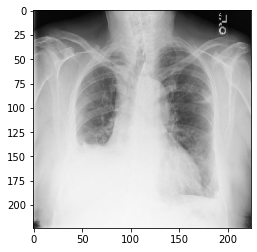

In [36]:
plt.imshow(valX[:,:,:,:][0])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


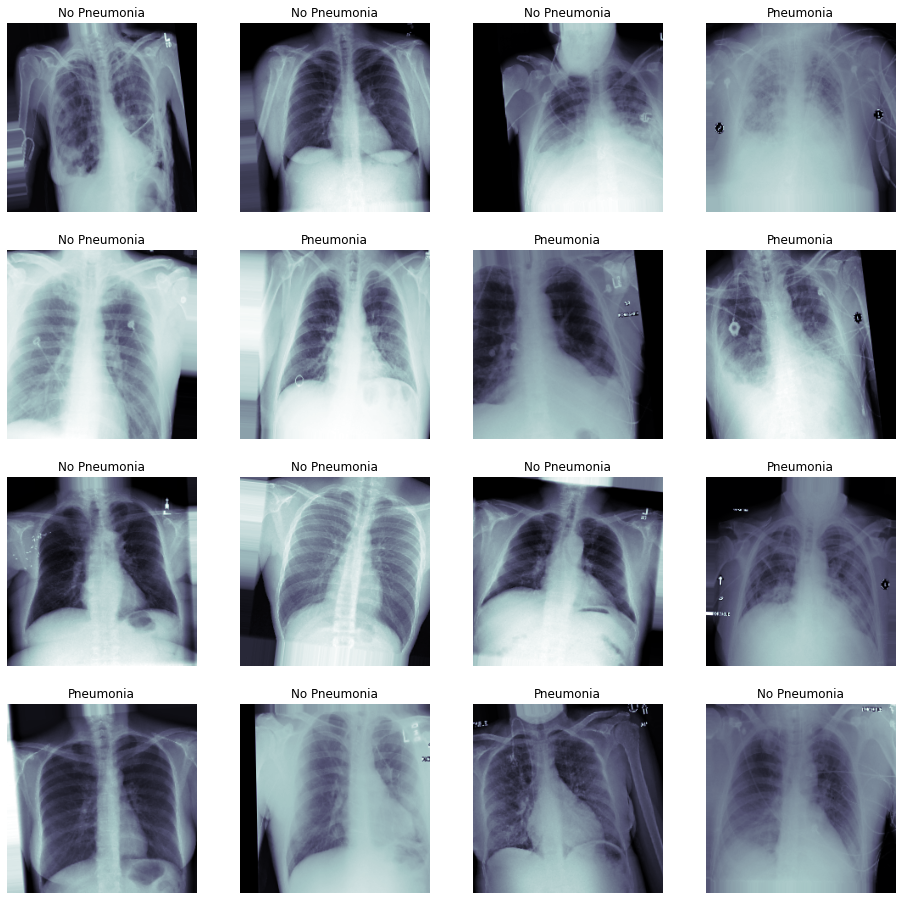

In [37]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [38]:

def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:-9]:
        layer.trainable = False
    return vgg_model


In [39]:
# From Udacity technical help
#    model = VGG16(include_top=True, weights='imagenet')
#    transfer_layer = model.get_layer('block5_pool')
#    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
#    for layer in vgg_model.layers[0:-9]:
#        layer.trainable = False

In [40]:
m = load_pretrained_model()

553467904/553467096 [==============================] - 7s 0us/step


In [41]:
m.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [42]:
def build_my_model(vgg_model):
    
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    ## Set our optimizer, loss function, and learning rate
    
    optimizer = Adam(lr=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [43]:
model_pne =  build_my_model(m)

In [44]:
model_pne.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [45]:
!pwd


/home/workspace


In [46]:
!ls /home/workspace

'Build and train model.ipynb'   Inference.ipynb         test1.dcm   test4.dcm
 EDA.ipynb		        pixel_analysis.pickle   test2.dcm   test5.dcm
 FDA_Submission_Template.md     sample_labels.csv       test3.dcm   test6.dcm


In [49]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

#weight_path="pneumonia-{epoch:02d}-{val_loss:.2f}_my_model.best.hdf5".format('xray_class')
weight_path = "PNEUMONIA-weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [50]:
## train your model

# Todo

history = model_pne.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


72/72 [==============================] - 65s 896ms/step - loss: 0.7954 - binary_accuracy: 0.5052 - val_loss: 0.4046 - val_binary_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.40456, saving model to PNEUMONIA-weights-01-0.40.hdf5
Epoch 2/100
72/72 [==============================] - 59s 821ms/step - loss: 0.7511 - binary_accuracy: 0.5096 - val_loss: 0.4557 - val_binary_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.40456
Epoch 3/100
72/72 [==============================] - 59s 819ms/step - loss: 0.7312 - binary_accuracy: 0.4921 - val_loss: 0.5796 - val_binary_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.40456
Epoch 4/100
72/72 [==============================] - 59s 814ms/step - loss: 0.7017 - binary_accuracy: 0.5144 - val_loss: 0.6058 - val_binary_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.40456
Epoch 5/100
72/72 [==============================] - 59s 815ms/step - loss: 0.6929 - binary_accuracy: 0.5192 - val_loss: 0.5

In [51]:
!ls


'Build and train model.ipynb'   PNEUMONIA-weights-01-0.40.hdf5	 test4.dcm
 EDA.ipynb		        sample_labels.csv		 test5.dcm
 FDA_Submission_Template.md     test1.dcm			 test6.dcm
 Inference.ipynb	        test2.dcm
 pixel_analysis.pickle	        test3.dcm


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [53]:
#history_dict = history.history
#json.dump(history_dict, open('HISTORY.PKL', 'w'))

In [54]:
!ls

'Build and train model.ipynb'   pixel_analysis.pickle		 test3.dcm
 EDA.ipynb		        PNEUMONIA-weights-01-0.40.hdf5	 test4.dcm
 FDA_Submission_Template.md     sample_labels.csv		 test5.dcm
 HISTORY.PKL		        test1.dcm			 test6.dcm
 Inference.ipynb	        test2.dcm


In [55]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
best_weights = 'PNEUMONIA-weights-01-0.40.hdf5'
# build a new model and load the weights
inference_model  =  build_my_model(m)
inference_model.load_weights(best_weights)
pred_Y = inference_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 13ms/step


In [73]:
#valX, valY = val_gen.next()
#pred_Y = inference_model.predict(valX, batch_size = 32, verbose = True)

In [56]:
def plot_auc(t_y, p_y):
    
    fpr, tpr, threshold = roc_curve(t_y,p_y)
    plt.plot(fpr, tpr, marker='.', label='ROC curve')
    return threshold

## what other performance statistics do you want to include here besides AUC? 

#precision = precision_score(y_true, y_pred, average='binary')

# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    return

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


array([1.3747015 , 0.37470156, 0.25592482], dtype=float32)

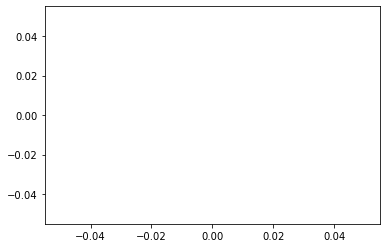

In [57]:
## plot figures

plot_auc(valY,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)